# Daily Weather Types

In [1]:
from utils.data import load_atmospheric_predictor

# Define the variables and region
variables = ["msl", "msl_gradient"]
region = (200, -10, 360, 80)
estela = True

# Load the ERA5 dynamic predictors
era5_dynamic = load_atmospheric_predictor(
    variables=variables, region=region, estela=estela
)
era5_dynamic

<xarray.Dataset> Size: 64MB
Dimensions:       (time: 8727, latitude: 23, longitude: 40)
Coordinates:
  * latitude      (latitude) float32 92B 79.62 75.62 71.62 ... -4.375 -8.375
  * time          (time) datetime64[s] 70kB 2000-01-01 2000-01-02 ... 2023-11-22
  * longitude     (longitude) float32 160B 200.4 204.4 208.4 ... 352.4 356.4
Data variables:
    msl           (time, latitude, longitude) float32 32MB nan nan ... nan nan
    msl_gradient  (time, latitude, longitude) float32 32MB nan nan ... nan nan

In [3]:
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.datamining.kma import KMA
from bluemath_tk.predictor.xwt import XWT

pca = PCA(n_components=0.95)
kma = KMA(num_clusters=36, seed=42)

xwt = XWT(steps={"pca": pca, "kma": kma})
xwt.fit(
    data=era5_dynamic,
    fit_params={
        "pca": {
            "vars_to_stack": variables,
            "coords_to_stack": ["latitude", "longitude"],
            "pca_dim_for_rows": "time",
            "value_to_replace_nans": {"msl": 101325.0, "msl_gradient": 0.0},
        },
        "kma": {
            "normalize_data": False,
            "min_number_of_points": 10,
            "max_number_of_iterations": 100,
        },
    },
    variable_to_sort_bmus="msl",
)
xwt.save_model("outputs/dwt_model_aveiro.pkl")

2025-04-02 13:58:56,737 - PCA - WARNING - Data contains NaNs.


2025-04-02 13:58:56,798 - PCA - WARNING - Data contains NaNs.



        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.95
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


2025-04-02 13:59:30,350 - PCA - WARNING - Attribute pcs is an xarray Dataset / Dataarray and will be pickled!


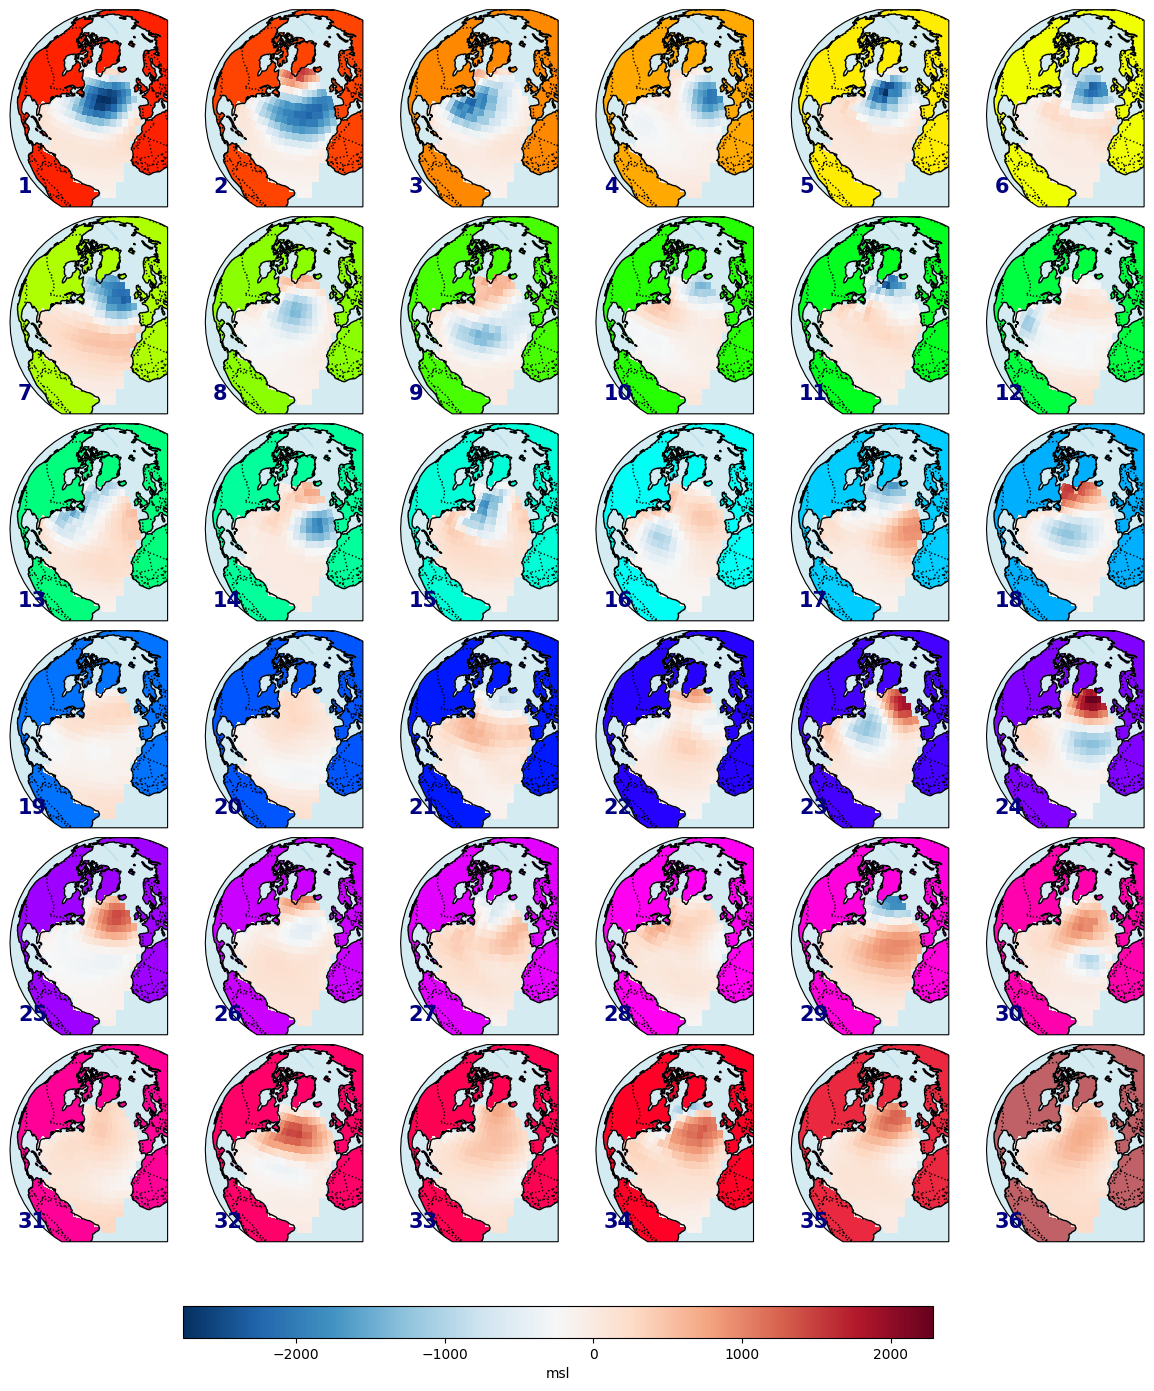

In [8]:
xwt.plot_xwts(var_to_plot="msl", anomaly=True, map_center=(-25, 40))

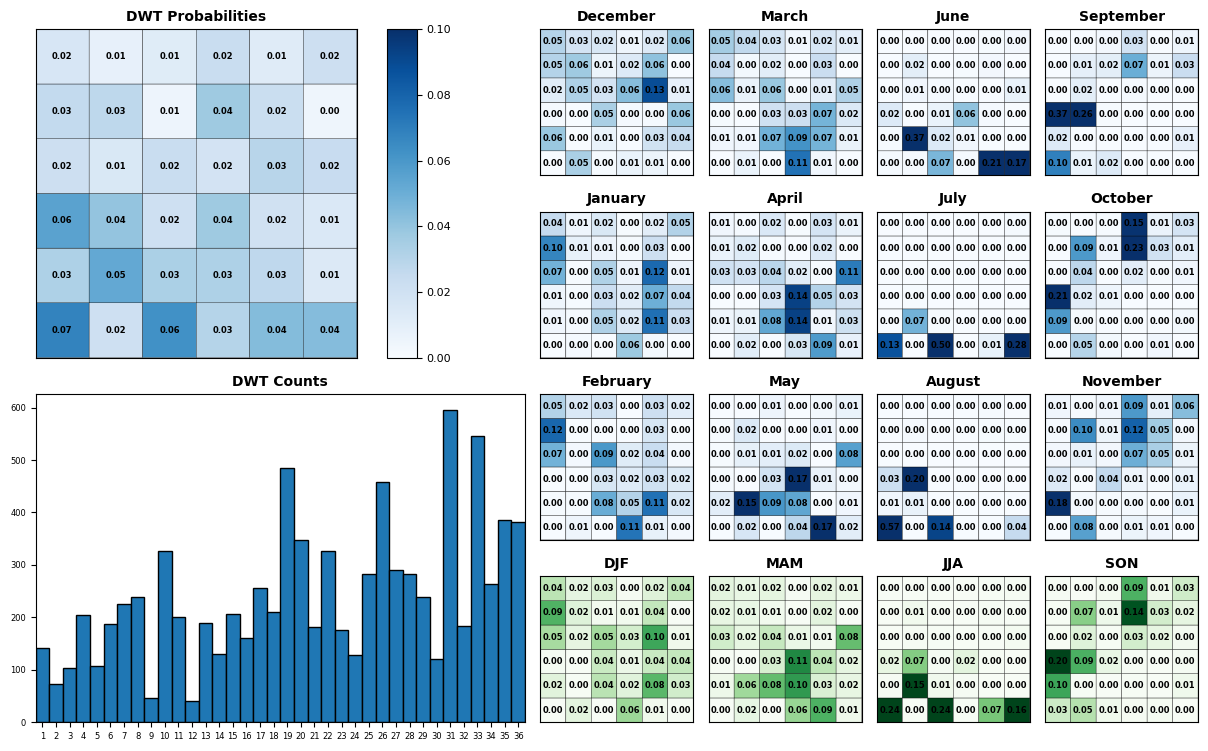

In [6]:
xwt.plot_dwts_probs(plot_text=True)

<Axes: >

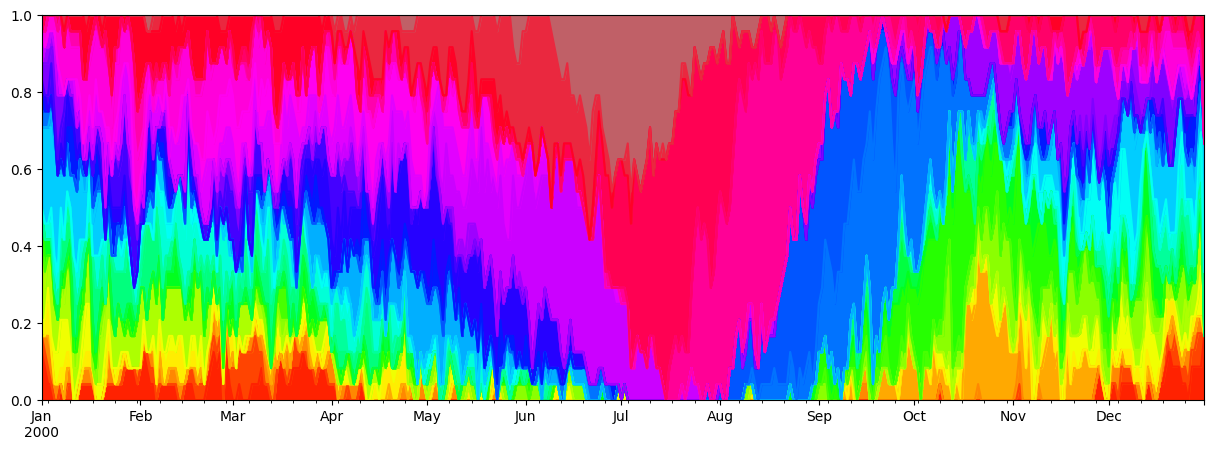

In [7]:
xwt.plot_perpetual_year()

## Load Waves data and group by clusters

In [9]:
import xarray as xr

waves = (
    xr.open_dataset("data/era5_aveiro.nc")
    .sel(time=slice("2000", None))
    .resample(time="1D").mean()
    .sel(time=xwt.kma_bmus.index, method="nearest", tolerance="1H")
)
waves["kma_bmus"] = (("time"), xwt.kma_bmus.kma_bmus.values)
waves

<xarray.Dataset> Size: 314kB
Dimensions:    (time: 8727)
Coordinates:
    longitude  float32 4B 350.5
    latitude   float32 4B 40.5
  * time       (time) datetime64[ns] 70kB 2000-01-01 2000-01-02 ... 2023-11-22
Data variables:
    swh        (time) float64 70kB 1.596 2.797 2.911 3.045 ... 2.45 3.17 2.216
    pp1d       (time) float64 70kB 13.7 14.63 14.46 14.76 ... 11.74 10.34 9.589
    mwd        (time) float64 70kB 313.3 305.6 307.0 309.8 ... 305.9 349.2 356.2
    kma_bmus   (time) int32 35kB 19 19 19 19 19 6 6 6 21 ... 8 8 19 19 8 8 21 25
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-24 23:51:43 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

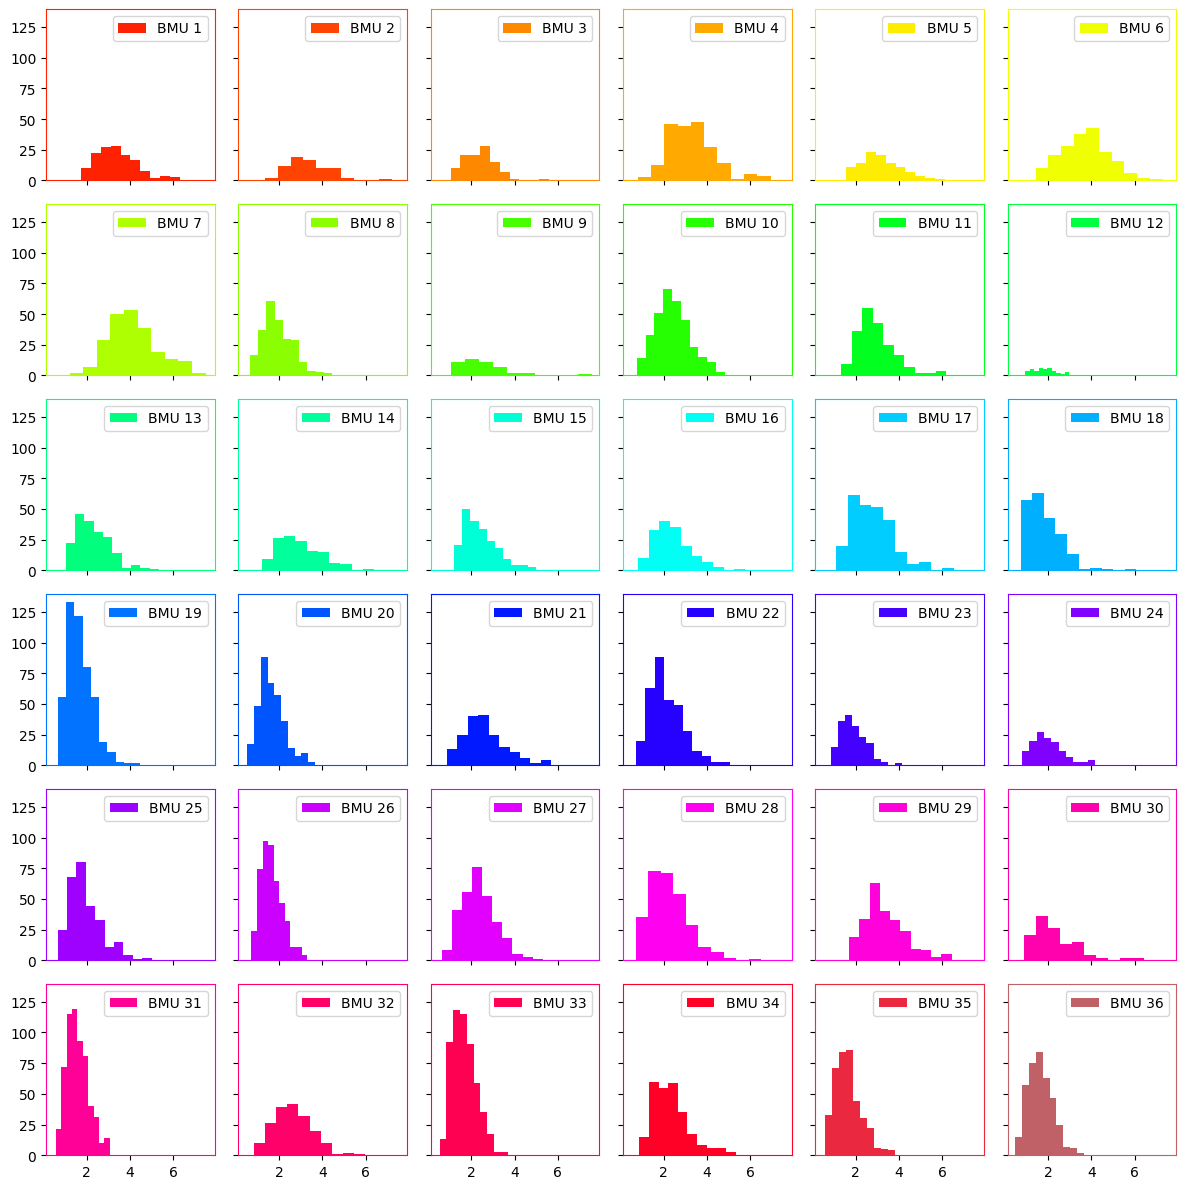

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from bluemath_tk.core.plotting.colors import get_cluster_colors

wave_variable = "swh"

cluster_colors = get_cluster_colors(xwt.num_clusters)
fig, axes = plt.subplots(6, 6, figsize=(12, 12), sharex=True, sharey=True)
for ax, kma_bmus_index, color in zip(axes.flatten(), range(1, 37), cluster_colors):
    bmus_indexes = np.where(waves["kma_bmus"].values == kma_bmus_index)[0]
    try:
        waves[wave_variable].isel(time=bmus_indexes).squeeze().plot.hist(
            ax=ax, color=color, label=f"BMU {kma_bmus_index}"
        )
        ax.legend()
        ax.set_title("")
        ax.set_xlabel("")
        for border in ["top", "bottom", "left", "right"]:
            ax.spines[border].set_color(color)
    except:
        pass
plt.tight_layout()